# Simple Case Using Cramer Rao Bound

Set up a spring-mass-damper system as a simple example to try this concept. Start by defining the system dynamics. 

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
from scipy.linalg import expm
from scipy.signal import cont2discrete

# Spring-mass-damper parameters
m = 1.0  # Mass (kg)
c = 0.5  # Damping coefficient (Ns/m)
k = 2.0  # Spring constant (N/m)

# Continuous-time state-space matrices
A_c = np.array([[0, 1],
                [-k/m, -c/m]])
B_c = np.array([[0],
                [1/m]])
C_true = np.eye(2)

C = [
    np.array([[1, 0], [0, 1]]),
    np.array([[1, 0], [0, 0]]),
    np.array([[0, 0], [0, 1]])
]

# Process and measurement noise
Q = np.array([[1e-4, 0], 
              [0, 1e-4]])  # Process noise covariance
R = np.array([[0.05, 0], 
              [0, 0.05]])  # Measurement noise covariance

# Discrete time system for kalman filter
dt = 0.1  # Time step
A_d = expm(A_c * dt)
B_d = np.linalg.solve(A_c, (A_d - np.eye(2))) @ B_c

# Initial conditions
x0 = np.array([1.0, 0.0])  # Initial displacement and velocity


Now, simulate the true system. 

In [115]:
# Simulate the true system
np.random.seed(42)
n_steps = 100 
true_states = []
measurements = []
for _ in range(n_steps):
    # Simulate true dynamics
    x_true = A_d @ x0 + np.random.multivariate_normal([0, 0], Q).T
    true_states.append(x_true)

    # Simulate noisy measurements
    z = C_true @ x_true + np.random.multivariate_normal([0, 0], R).T
    measurements.append(z)

    # Update for the next time step
    x0 = x_true

true_states = np.array(true_states)
measurements = np.array(measurements)

Then, use the  Kalman filter to generate state estimates from simulated measurments. Make sure to use the 3 sigma bound to set up the estimation range. This block runs the Kalman Filter for every subgroup of C matrices. 

In [116]:
filtered_states = []
three_sigma = []

for i in range(len(C)):
    system = (A_c, B_c, np.eye(2), 0)
    A_d, B_d, _, _, _ = cont2discrete(system, dt)
    Q = np.eye(2) * 1e-4
    R = np.eye(C[i].shape[0]) * 0.05

    # Kalman Filter setup
    kf = KalmanFilter(dim_x=2, dim_z=2)
    kf.F = A_d  # Discretized A matrix
    kf.H = C_true  # Measurement matrix C
    kf.Q = Q  # Process noise covariance Q
    kf.R = R  # Measurement noise covariance R
    kf.P = np.eye(2) * 500  # Initial state covariance P
    kf.x = x0  # Initial state estimate

    state_at_this_C = []
    uncertainty_at_this_C = []

    for z in measurements:
        kf.predict()
        kf.update(z)
        state_at_this_C.append(kf.x.copy())
        uncertainty_at_this_C.append(3 * np.sqrt(np.diag(kf.P))) # make sure to multiply by 3 for 3 sigma!!!
    
    filtered_states.append(state_at_this_C)
    three_sigma.append(uncertainty_at_this_C)


Finally, plot the results. 

TypeError: list indices must be integers or slices, not tuple

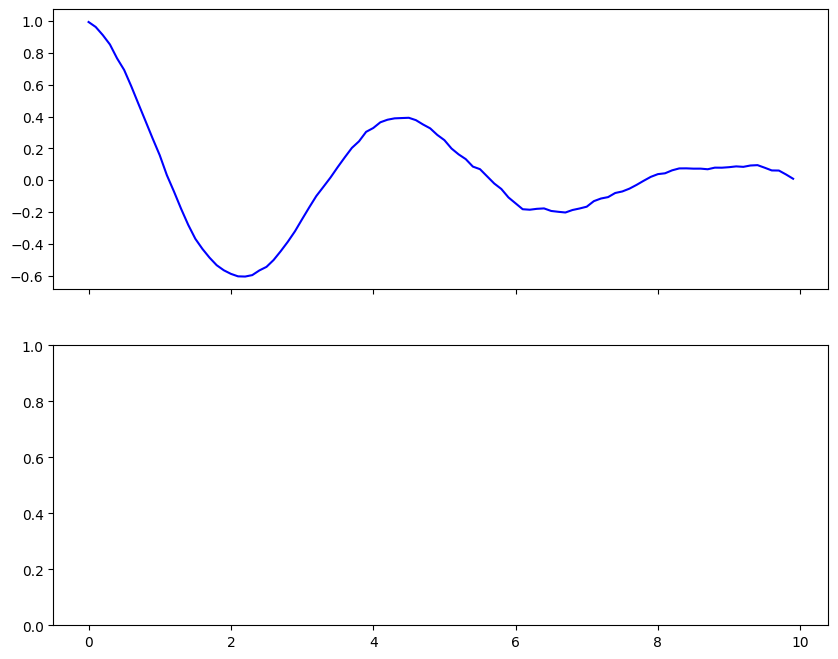

In [117]:
#Create a time vector based on the number of steps and time step size
time = np.arange(0, n_steps * dt, dt)  # Total simulation time

# Plot results with confidence intervals and time in seconds
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Position
axs[0].plot(time, true_states[:, 0], label="True Position", color="blue")
axs[0].plot(time, filtered_states[:, 0], label="Estimated Position", linestyle="--", color="green")
axs[0].fill_between(time, 
                    filtered_states[:, 0] - three_sigma[:, 0],
                    filtered_states[:, 0] + three_sigma[:, 0],
                    color="green", alpha=0.2, label="3 sigma")
axs[0].set_ylabel("Position (m)")
axs[0].set_title("Spring-Mass-Damper System: Kalman Filter with 3 sigma bounds")
axs[0].set_ylim(-1, 2)
axs[0].legend()
axs[0].grid()

# Velocity
axs[1].plot(time, true_states[:, 1], label="True Velocity", color="blue")
axs[1].plot(time, filtered_states[:, 1], label="Estimated Velocity", linestyle="--", color="green")
axs[1].fill_between(time, 
                    filtered_states[:, 1] - three_sigma[:, 1],
                    filtered_states[:, 1] + three_sigma[:, 1],
                    color="green", alpha=0.2, label="3 sigma")
axs[1].set_ylabel("Velocity (m/s)")
axs[1].set_xlabel("Time (s)")  # Label the x-axis with time
axs[1].set_ylim(-2, 2)
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()